# What is t-SNE?

[The original paper](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) that proposes the t-SNE describes it as follows:

> “t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding” - van der Maaten, Hinton, 2008.

Like PCA, t-SNE is a dimensionality reduction technique that tries to find a good representation of the high-dimensional data in the low-dimensional space. In order to accomplish this, t-SNE measures the similarity between the data points both in high-dimensional space and low-dimensional space and then tries to minimize the divergence between the two similarities calculated in the high and the low dimensional spaces. In order to understand where the t-SNE idea comes from and its differences between the other dimensionality reduction techniques, we suggest you to watch [this video](https://www.youtube.com/watch?v=RJVL80Gg3lA) where Laurens van der Maaten discusses the t-SNE algorithm.

Before presenting the t-SNE algorithm, let's provide a brief comparison of PCA and t-SNE to better understand what the later accomplishes.

# Differences between PCA and t-SNE

1. PCA tries to preserve the large pairwise distances between the data points whereas t-SNE tries to preserve the small pairwise distances between them. **Hence, t-SNE better represents the local similarities in the data whereas PCA better represents the dissimilarities in the data**. That is to say, if two points are close together in the high dimensional space, they have a high probability of being close together in the low dimensional space that t-SNE produces.

2. PCA is a linear method that tries to retain the variance in the data as much as it can whereas t-SNE is a non-linear method that minimizes the divergence between the distributions of high-dimensional data and the low-dimensional representation it produces. This means that PCA suffers in discovering non-linear relationships between the observations. **Hence, instead of PCA we should use t-SNE to preserve the similarities between the observations that can only be measured in a non-linear way**. This makes t-SNE very useful especially for image, audio and text data where non-linearity is pretty common.

Considering the points above, we can say that you should prefer to use t-SNE especially for image, audio and text data. However, as we'll touch upon soon, the runtime of t-SNE is much higher than the PCA and this makes a trade-off between speed and information when choosing between PCA and t-SNE.

# t-SNE algorithm

Now, let's talk about the algorithm that t-SNE uses to produce the lower-dimensional representation of the data. The algorithm consists of three steps and we discuss each step with a blend of math to present ideas more clearly.

Let $\left| x_i - x_j \right|$ denote the Euclidean distance (L2 norm) between two data points in the original space, and $\left| y_i - y_j \right|$ denote the distance between the associated points in the lower-dimensional representation.

1. t-SNE starts with calculating a similarity matrix between the data points in the original high-dimensional space using this equation:

$$ p_{j|i} = \frac{\exp\left(-\left| x_i - x_j\right|^2 \big/ 2\sigma_i^2\right)}{\displaystyle\sum_{k \neq i} \exp\left(-\left| x_i - x_k\right|^2 \big/ 2\sigma_i^2\right)}$$

This measures how much distant $x_j$ is from $x_i$, considering a Gaussian distribution around $x_i$ with a given variance $\sigma_i^2$. Using Gaussian distribution is an assumption of the t-SNE algorithm and the variance for each point is different from each other. These variances are chosen such that points in dense areas are given a smaller variance than points in sparse areas. We won't go into the details of how this variance is computed, but you can read it in the original paper.

Notice that according to the equation above, $p_{j|i}$ and $p_{i|j}$ might differ. In order to overcome this issue, t-SNE defines the similarity as a symmetrized version of the conditional similarities:

$$ p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$$ 


2. Next, t-SNE calculates another similarity matrix this time between the data points in the reduced low-dimensional space using this equation:

$$ q_{ij} = \frac{f(\left| x_i - x_j\right|)}{\displaystyle\sum_{k \neq i} f(\left| x_i - x_k\right|)}\: , with\: f(z) = \frac{1}{1+z^2}$$

This is the same idea as above, but in the lower-dimensional space t-SNE uses a different distribution which is called the **t-Student distribution** with one degree of freedom, also known as **Cauchy distribution**. This is another assumption of the t-SNE algorithm and we'll explain why the two distribution choices are different.

Now, if the similarity matrix $\big(p_{ij}\big)$ in the original space is fixed, the similarity matrix $\big(q_{ij}\big)$ in the reduced space depends on how we choose the representation points. t-SNE wants these two matrices to be as close as possible which in turn ensures that similar data points yield similar representation points.

3. In the last step, t-SNE tries to minimize the **Kullback-Leiber (KL) divergence** between the original similarity distribution and the reduced representation distribution. Kullback-Leiber divergence is a measure of how much two distributions differ from each other. For the two distributions $P$ and $Q$, Kullback-Leiber divergence is defined as:

$$ KL(P||Q) = \sum_{i, j} p_{ij}  \log \frac{p_{ij}}{q_{ij}}$$

This measures the distance between our two similarity matrices.

To minimize this score, t-SNE performs gradient descent. The gradient can be computed analytically:

$$ \frac{\partial , KL(P || Q)}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij}) g\left( \left| x_i - x_j\right| \right) u_{ij}\: , where\: g(z) = \frac{z}{1+z^2}$$

Here, $u_{ij}$ is a unit vector going from $y_j$ to $y_i$.

All the iterations we see in the gif above is due to the optimization process of the KL divergence using the gradient descent method. At each iteration, the lower-dimensional representation is upgraded so that the KL divergence of it between the high-dimensional representation is reduced.

## Why does t-SNE use Cauchy distribution instead of Gaussian for the similarity in the lower-dimension?

You may wonder why t-SNE uses different distributions to model the similarity in the original and the reduced spaces.  To understand why, let's give an example where we transform three points in two-dimensional space into one-dimensional space.

In the left part of the image below, the distances between three points in two-dimensional space are given. The distance between the first and the third points are also shown as a red line. In the right part of the image, two different reduced representations using t-SNE are given. In the upper part, the transformation is done using Gaussian distribution and in the bottom part the transformation is done using Cauchy distribution:

![t-sne distributions](./assets/t-sne_distributions.png)

As you see, when we use Cauchy distribution the distance between the first and the third points become more emphasized as they placed more further away from each other on the line in comparison to the Gaussian distribution. In effect, using Cauchy distribution enables t-SNE to separate away the dissimilar points in the reduced space. Hence, in this way t-SNE tries to retain local similarities and highlight the global dissimilarities in the low-dimensional space. We'll see how successfull t-SNE achieves this on the MNIST data later in this checkpoint.

But, what is the difference between Cauchy and Gaussian distributions? As you can see in the figure below, Cauchy distribution is more fat tailed than the Gaussian distribution:

![cauchy vs gaussian](./assets/cauchy_vs_gaussian.png)

When reducing the dimensionality of a dataset, if we were to use the same Gaussian distribution for the original data points and the reduced ones, we would get an imbalance in the distribution of the distances of a point's neighbors. This is because the distribution of the distances is so different between a high-dimensional space and a low-dimensional space. Yet, the algorithm tries to reproduce the same distances in the two spaces. 

The t-SNE algorithm works around this problem by using Cauchy distribution in the lower-dimensional space. This distribution has a much heavier tail than the Gaussian distribution, which compensates the original imbalance. For a given similarity between two data points, the two corresponding lower-dimensional representation will need to be much further apart in order for their similarity to match the data similarity.

# Important points to consider

* t-SNE is not a clustering algorithm but a dimensionality reduction algorithm. Hence we shouldn't make any inference based only on the output of t-SNE. We use it mainly for data exploration and visualization. Cluster sizes in t-SNE plots must not be evaluated for variance or dispersion. Because, t-SNE expands denser clusters and contracts sparser clusters to make them similar sized. This is one of the reasons for the clear plots it produces.

* If we have variables of different scales and we want t-SNE to treat each variable equally, then standardizing the features before applying t-SNE is important. Especially the L2 norm (Euclidean distance) is sensitive to the scaling of the data.

* t-SNE scales quadratically in the number of observations. This limits its applicability to data sets with only a few thousand data points. For larger datasets, computation time of t-SNE becomes too high. The algorithm we'll introduce in the next checkpoint is more suitable for large datasets.

* Similar to the point above, t-SNE also runs very slowly if the dimensionality of the data is too large. So, it is a common practice to reduce dimension (to 50 for example) first using another dimensionality reduction algorithm like PCA.

* t-SNE is a probabilistic algorithm. So, different runs with the same hyperparameters may produce different results. So, we should be careful when analyzing the data based on a single t-SNE plot. If possible, multiple plots must be observed before making any assessment.

* **Hyperparameters**: When applying t-SNE, we should make some decisions on the values of the algorithm's hyperparameters. The hyperparameters of t-SNE are the perplexity and the number of iterations to stop. For the algorithm to execute properly, the perplexity should be smaller than the number of points. Also, the suggested perplexity is in the range of (5 to 50). However, the best way to decide on the values of the hyperparameters is to apply k-fold cross-validation.

# Speed

t-SNE computes pairwise conditional probabilities and tries to minimize the sum of the difference of the probabilities in the original and the lower dimensions. This involves a lot of calculations and computations. Actually, the algorithm has quadratic time and space complexity in the number of data points. This makes it a slow algorithm as well as resource consuming when applied to data comprising of more than 10,000 observations. 

So, using t-SNE for large datasets might be impractical. In order to reduce the computational time, we'll present another algorithm in the next checkpoint that is similar to t-SNE on achievements but runs much faster.

# t-SNE in action

Now, we demonstrate how we apply t-SNE and what it produces on the MNIST dataset. Remember from the previous checkpoint that MNIST is a dataset comprising of hand-written digit images. When we attempted to visualize MNIST images in two-dimensional space using PCA, we saw that PCA only highlighted how far the digits are away from each other and not how close the similar digits are. Here, we apply t-SNE to the MNIST data and see that the same digits cluster together and distinct digits separates away from each other.

We begin by importing the libraries we use. Notice that t-SNE lives in the `manifold` module of the scikit-learn:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

As usual, we load the MNIST dataset using the `fetch_openml` function of the `sklearn.datasets`.

**Note**: You don't have to use this method to download the MNIST dataset. It's available online [here](http://yann.lecun.com/exdb/mnist/). You can also download the dataset from that link and then load it in your own way. Notice that the dataset in the link is separated into two (as training and test sets), but we use the combined version. You can combine the train and test sets into one or you can just use the train set. The results should look similar to each other.

If you want to use `fetch_openml` function and your version of scikit-learn is older than `0.20`, you can run the following code on the command line to upgrade your installation:

```bash
pip install --upgrade scikit-learn
```

Once you get the required version, you can now load the MNIST data: 

In [2]:
mnist = mnist = fetch_openml('mnist_784', version=1, cache=True)

As we said before, t-SNE runs slow especially when applied to datasets that are larger than 10000 observations. Because of this, we randomly select 10000 sample from the 70000 images of the MNIST. We apply t-SNE on this sample.

In [3]:
np.random.seed(123)

indices = np.random.choice(70000,10000)
X = mnist.data[indices] / 255.0
y = mnist.target[indices]

print(X.shape, y.shape)

(10000, 784) (10000,)


It's time to apply t-SNE. Since, we want to visualize the MNIST data in two-dimensions, we set `n_components=2` in the `TSNE` class. We also set `perplexity=40` and `n_iter=300`. You can play with the perplexity and the number of iterations and compare the results.

In [4]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.520s...
[t-SNE] Computed neighbors for 10000 samples in 117.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.182897
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.157776
[t-SNE] KL divergence after 300 iterations: 2.811233
t-SNE done! Time elapse

Now, we can plot the MNIST data using the t-SNE components. In the figure below, we colored and labeled each data point according to its true digit to help our understanding of how useful t-SNE representions are:

In [5]:
plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], str(y[i]),
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

All the digit classes seem to be separated from each other quite well in contrast to PCA representation. This is because of the fact that t-SNE preserves the local similarities. Since the observations that belong to the same digit class are similar to each other, in the two-dimensional representation of t-SNE we see them clustered together. This is something great as in a realistic scenario we may have no access to the class or group information of the examples. Even in this case, we can be able to identify the different groups from t-SNE's low-dimensional representations. To illustrate this, we plot the same graph above this time without coloring or labeling the data points: 

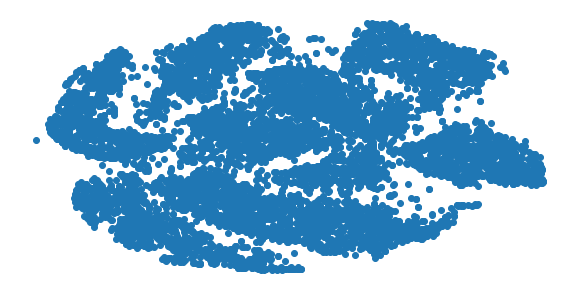

In [6]:
plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

We can clearly identify nine different groupings above. The only indistinguishable digits are the *four* and *nine* as they intertwined each other at the bottom of the graph. If you have enough resources and time, you can run the t-SNE algorithm on the full MNIST data (60000 images) and check whether t-SNE could come up with a representation that also distinguish between fours and nines. 